In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import glob

sys.path.append("../../prrr/models")
from prrr import PRRR
from grrr import GRRR
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib
font = {"size": 15}
matplotlib.rc("font", **font)

tissue_expression_files = glob.glob("../../data/GTEx_gene_expression/*")
# tissue_expression_files = ["../../data/GTEx_gene_expression/gtex_expression_Lung.csv"]

In [2]:
data = pd.read_excel("../../data/gtex/GTEx_Analysis_2015-01-12_Annotations_SubjectPhenotypesDD.xlsx")
integer_varnames = data.VARNAME.values[["encoded value" in x for x in data.TYPE.values]]
integer_varnames[1] = 'SEX'
# integer_varnames = [i for i in integer_varnames if i.startswith('MH')]
use_varnames = []
for x in integer_varnames:
    s = v8_metadata[x].value_counts().to_frame()
    try:
        if s.loc[1, x] > 5:
            use_varnames.append(x)
    except:
        continue

NameError: name 'v8_metadata' is not defined

In [ ]:
use_varnames

In [ ]:
decimal_varnames = data.VARNAME.values[["decimal" in x for x in data.TYPE.values]]
decimal_varnames

In [3]:
i = 1
for f in tissue_expression_files:    
    EXPRESSION_FILE = f
    print(EXPRESSION_FILE)
    METADATA_PATH = (
        "../../data/GTEx_metadata/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt"
    )
    NUM_GENES = 5000
#     TISSUE = ""

    expression_data = pd.read_csv(EXPRESSION_FILE, index_col=0)
    v8_metadata = pd.read_table(METADATA_PATH)


    ## Align subjects
    subj_ids_expression = expression_data.index.str.split("-").str[:2].str.join("-")
    expression_data["SUBJID"] = subj_ids_expression
    shared_subj_ids = np.intersect1d(subj_ids_expression, v8_metadata.SUBJID.values)
    v8_metadata.index = v8_metadata.SUBJID.values
    v8_metadata = v8_metadata.transpose()[shared_subj_ids].transpose()

    expression_data = expression_data.drop_duplicates("SUBJID")
    expression_data.index = expression_data["SUBJID"]
    expression_data = expression_data.transpose()[shared_subj_ids].transpose()

    expression_data = expression_data.drop("SUBJID", axis=1)

    assert np.array_equal(v8_metadata.index.values, expression_data.index.values)


    # Get most variable genes
    n_genes = 200
    Y = expression_data.values.astype(int)
    Ylog = np.log(Y + 1)
    gene_vars = Ylog.std(0)
    sorted_idx = np.argsort(-gene_vars)

    Y = Y[:, sorted_idx[:n_genes]]


    # Pick a few metadata columns
    metadata_cols = []
    dummy_vars = use_varnames
    nondummy_vars = np.setdiff1d(metadata_cols, dummy_vars)
    dummy_list = []
    for dummy_var in dummy_vars:
        curr_dummies = pd.get_dummies(v8_metadata[dummy_var]).rename(columns=lambda x:dummy_var + '_' + str(x))
        dummy_list.append(curr_dummies)
        
        
    for nondummy_var in nondummy_vars:
        v8_metadata[nondummy_var] = (v8_metadata[nondummy_var] - v8_metadata[nondummy_var].mean()) / v8_metadata[nondummy_var].std()

    X_df = pd.concat(dummy_list, axis=1)
#     X_df = pd.DataFrame()

    for nondummy_var in nondummy_vars:
        X_df = pd.concat([X_df, v8_metadata[nondummy_var]], axis=1)
    
    # cut out unknowns
    X_df_un = X_df.columns.values[[("_96" in x) or ("_97" in x) or ("_98" in x) or ("_99" in x) for x in X_df.columns.values]]
    X_df = X_df.drop(columns = X_df_un, axis = 1)

    # Fit model
    k = 2
#     prrr = PRRR(k)
    grrr = GRRR(k)
    cell_total_counts = np.expand_dims(Y.sum(1).astype("float32"), 1)

    rrr_results_g = grrr.fit(X=X_df.values, Y=Y, size_factors=cell_total_counts, use_vi=False)
#     rrr_results_p = prrr.fit(X=X_df.values, Y=Y, size_factors=cell_total_counts)

    A = grrr.param_dict["A"].numpy()
    B = grrr.param_dict["B"].numpy()
    AB_est_g = A @ B
    

    cur = plt.figure(i, figsize=(10, 50))
    i += 1
    sns.clustermap(pd.DataFrame(AB_est_g, index=X_df.columns), figsize=(10, 50), yticklabels=True).fig.suptitle(f)

plt.show()

../../data/GTEx_gene_expression/gtex_expression_Whole Blood.csv


ValueError: No objects to concatenate

In [80]:
A = grrr.param_dict["A"].numpy()
B = grrr.param_dict["B"].numpy()
AB_est_g = A @ B

A_lognormal_mean = prrr.param_dict["A_lognormal_mean"].numpy()
A_stddev = prrr.param_dict["A_lognormal_stddev"].numpy()
B_lognormal_mean = prrr.param_dict["B_lognormal_mean"].numpy()
B_stddev = prrr.param_dict["B_lognormal_stddev"].numpy()

A_est = np.exp(A_lognormal_mean + 0.5 * A_stddev ** 2)
B_est = np.exp(B_lognormal_mean + 0.5 * B_stddev ** 2)
AB_est_p = A_est @ B_est

# cur = plt.figure(i, figsize=(7, 7))
# plt.scatter(AB_est[0, :], AB_est[1, :])
# plt.xlabel("Gene coefficients (male)", fontsize=25)
# plt.ylabel("Gene coefficients (female)", fontsize=25)
# plt.tight_layout()
# # plt.savefig("../../figures/plots/gtex_male_vs_female.png")
# cur2 = plt.figure(i, figsize=(7, 7))
# sns.heatmap(AB_est_g)
# plt.show()

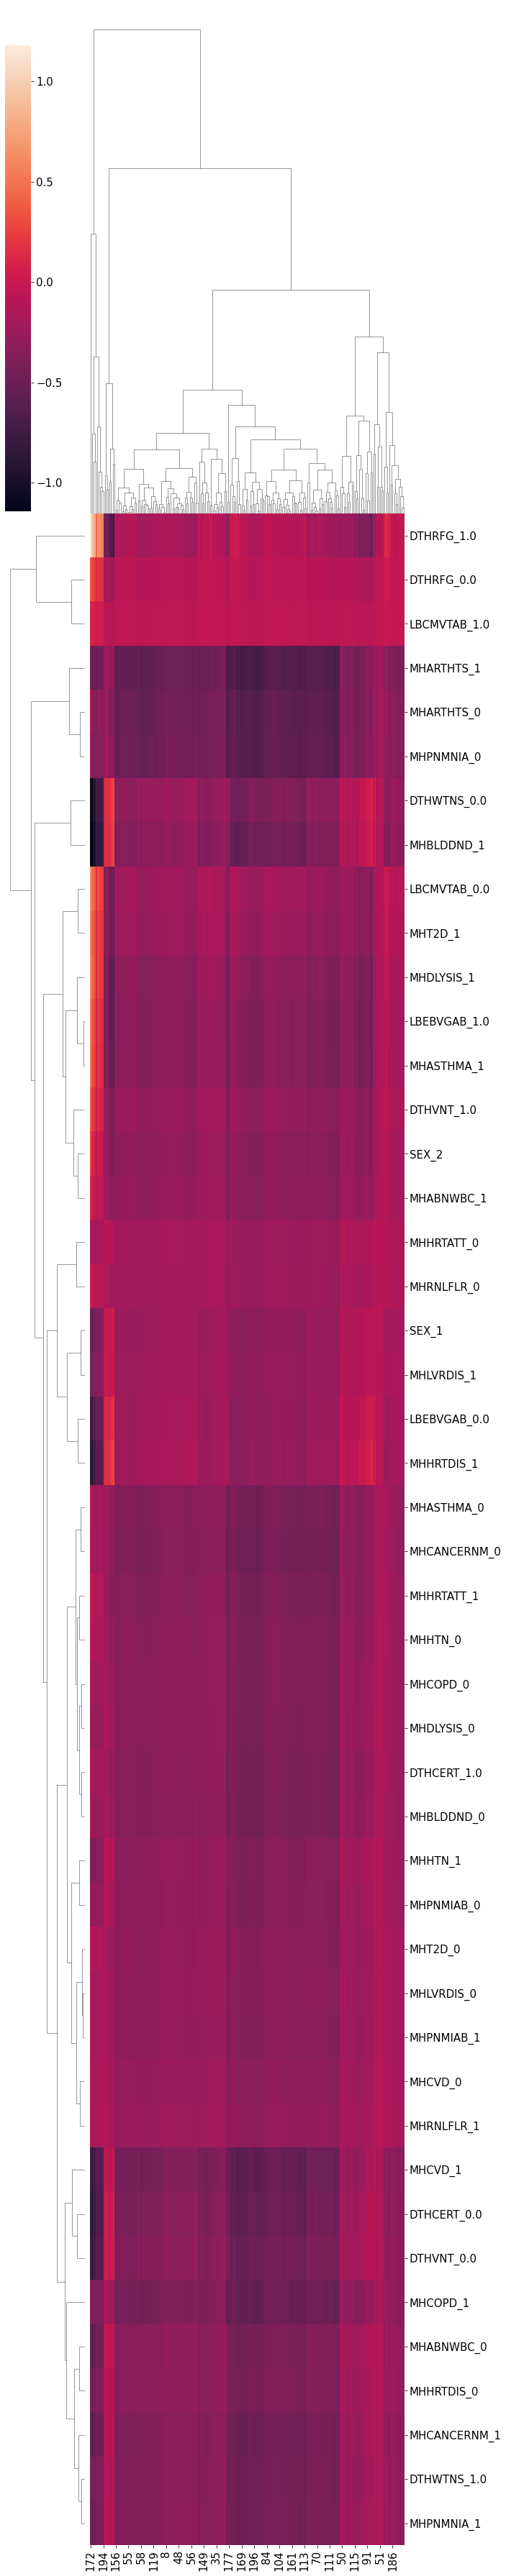

In [83]:
sns.clustermap(pd.DataFrame(AB_est_g, index=X_df.columns), figsize=(10, 50), yticklabels=True)

In [53]:
X_df.columns

Index(['ETHNCTY_0', 'ETHNCTY_1', 'SEX_1', 'SEX_2', 'RACE_1', 'RACE_2',
       'RACE_3', 'RACE_4', 'DTHATPSY_0.0', 'DTHATPSY_1.0',
       ...
       'MHUK8096_1', 'MHUREMIA_0', 'MHWKNSSU_0', 'MHWKNSSU_1', 'MHWNVCT_0',
       'MHWNVHX_0', 'MHWTLSUA_0', 'MHWTLSUA_1', 'MHWTLSUB_0', 'MHWTLSUB_1'],
      dtype='object', length=238)

In [28]:
v8_metadata["ETHNCTY"].value_counts()

0     165
99     79
98      7
1       3
Name: ETHNCTY, dtype: int64

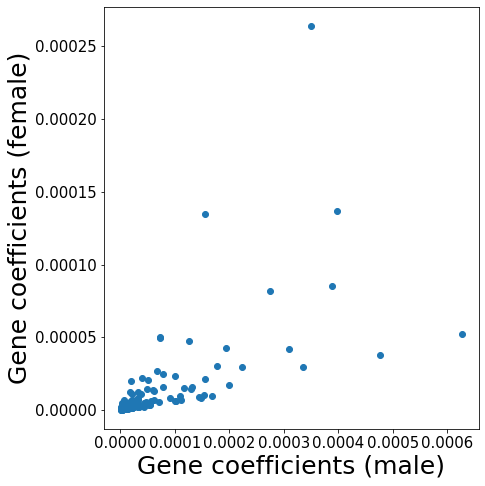

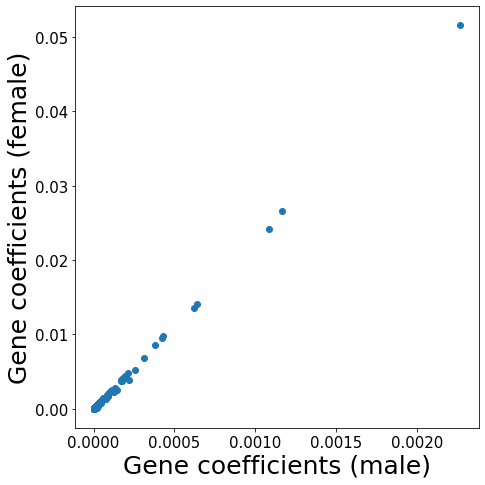

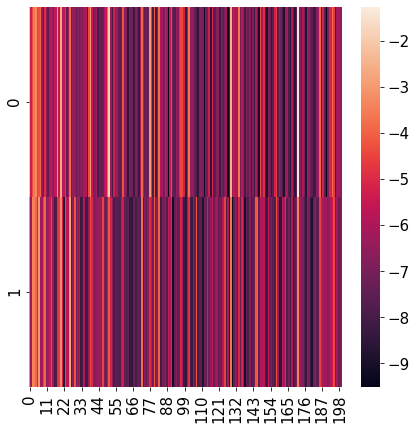

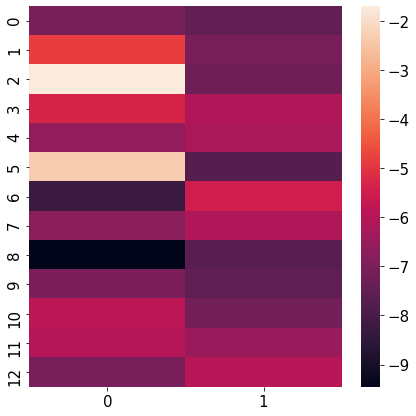

In [101]:
cur1 = plt.figure(1, figsize=(7, 7))
plt.scatter(AB_est[8, :], AB_est[9, :])
plt.xlabel("Gene coefficients (male)", fontsize=25)
plt.ylabel("Gene coefficients (female)", fontsize=25)
plt.tight_layout()  

cur2 = plt.figure(2, figsize=(7, 7))
plt.scatter(AB_est[1, :], AB_est[2, :])
plt.xlabel("Gene coefficients (male)", fontsize=25)
plt.ylabel("Gene coefficients (female)", fontsize=25)
plt.tight_layout()  

cur3 = plt.figure(3, figsize=(7, 7))
sns.heatmap(B_lognormal_mean)

cur4 = plt.figure(4, figsize=(7, 7))
sns.heatmap(A_lognormal_mean)

plt.show()

<AxesSubplot:>

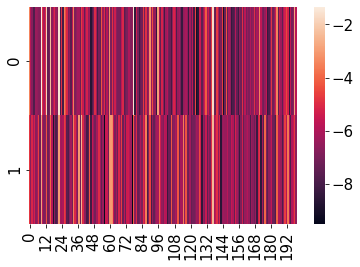

In [46]:
sns.heatmap(B_lognormal_mean)

<AxesSubplot:>

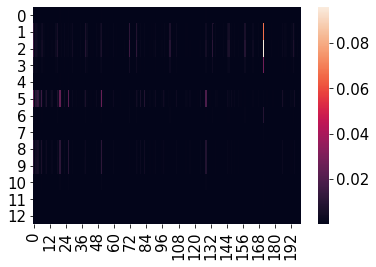

In [87]:
sns.heatmap(AB_est)

In [84]:
X_df.columns

Index([1, 2, 1, 2, 3, 99, 0, 1, 98, 99, 'HGHT', 'WGHT'], dtype='object')

In [68]:
use_varnames = []
for x in integer_varnames:
    s = v8_metadata[x].value_counts().to_frame()
    try:
        if s.loc[1, x] > 5:
            print(s)
            use_varnames.append(x)
    except:
        continue

   SEX
1   66
2   19
      DTHCERT
1.0        58
0.0        26
99.0        1
      DTHRFG
99.0      49
0.0       22
1.0       14
     DTHVNT
0.0      58
1.0      27
     DTHWTNS
1.0       79
0.0        6
      LBCMVTAB
97.0        63
1.0         14
0.0          7
      LBEBVGAB
97.0        64
1.0         19
0.0          1
    MHABNWBC
0         59
1         24
99         2
   MHARTHTS
0        79
1         6
   MHASTHMA
0        75
1        10
   MHBLDDND
0        77
1         8
   MHCANCERNM
0          78
1           7
   MHCOPD
0      60
1      25
   MHCVD
0     78
1      7
    MHDLYSIS
0         78
1          6
99         1
   MHHRTATT
0        64
1        21
    MHHRTDIS
0         64
1         20
99         1
    MHHTN
1      58
0      26
99      1
   MHLVRDIS
0        75
1        10
    MHPNMIAB
0         74
1         10
99         1
   MHPNMNIA
0        75
1        10
   MHRNLFLR
0        66
1        19
    MHT2D
0      60
1      24
99      1


In [108]:
tissue_expression_files

['../../data/GTEx_gene_expression/gtex_expression_Brain - Nucleus accumbens (basal ganglia).csv',
 '../../data/GTEx_gene_expression/gtex_expression_Nerve - Tibial.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Brain - Hypothalamus.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Brain - Cortex.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Whole Blood.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Pancreas.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Esophagus - Muscularis.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Cervix - Ectocervix.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Brain - Putamen (basal ganglia).csv',
 '../../data/GTEx_gene_expression/gtex_expression_Esophagus - Mucosa.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Lung.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Cervix - Endocervix.csv',
 '../../data/GTEx_gene_expression/gtex_expression_Brain - Substantia nigra.csv',
 '../../data/G